In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Load Data
data = pd.read_csv('/content/linear_regression_3.csv')
X = data.drop(columns='y')
y = data['y']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Step 3: Add Constant
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)





FileNotFoundError: [Errno 2] No such file or directory: '/content/linear_regression_3.csv'

In [ ]:
# Step 4: Remove High VIF Features
def remove_high_vif(X, y, threshold=5.0):
    removed = []
    X_copy = X.copy()
    while True:
        vif = pd.Series([variance_inflation_factor(X_copy.values, i)
                         for i in range(X_copy.shape[1])],
                        index=X_copy.columns)
        max_vif = vif.drop('const').max()
        if max_vif > threshold:
            feature_to_remove = vif.drop('const').idxmax()
            X_copy = X_copy.drop(columns=[feature_to_remove])
            removed.append(feature_to_remove)
            print(f"Removed '{feature_to_remove}' due to high VIF: {max_vif:.2f}")
        else:
            break
    return X_copy, removed

X_train_vif, vif_removed = remove_high_vif(X_train_const, y_train)
X_test_vif = X_test_const[X_train_vif.columns]
print("Features removed due to high VIF:", vif_removed)

# Step 5: Model after VIF filtering
model_vif = sm.OLS(y_train, X_train_vif).fit()
r2_train_vif = model_vif.rsquared
print(f"Train R² after VIF removal: {r2_train_vif:.4f}")

In [ ]:
# Step 6: Outlier Removal - Cook’s Distance
influence = model_vif.get_influence()
cooks_d = influence.cooks_distance[0]
threshold = 4 / len(X_train_vif)
non_outliers = cooks_d < threshold
X_train_cook = X_train_vif[non_outliers]
y_train_cook = y_train[non_outliers]
print(f"Removed {sum(~non_outliers)} training outliers using Cook's distance")

Removed 70 training outliers using Cook's distance


In [ ]:
# Step 7: Remove High p-Value Features
def remove_high_pvalue(X, y, p_threshold=0.05):
    removed = []
    while True:
        model = sm.OLS(y, X).fit()
        pvals = model.pvalues.drop('const')
        if (pvals > p_threshold).any():
            feature_to_remove = pvals.idxmax()
            X = X.drop(columns=[feature_to_remove])
            removed.append(feature_to_remove)
            print(f"Removed '{feature_to_remove}' due to high p-value: {pvals[feature_to_remove]:.4f}")
        else:
            break
    return X, removed

X_train_final, pval_removed = remove_high_pvalue(X_train_cook, y_train_cook)
X_test_final = X_test_vif[X_train_final.columns]
print("Features removed due to high p-value:", pval_removed)

# Step 8: Final Model Training
final_model = sm.OLS(y_train_cook, X_train_final).fit()
print("Train R² after Cook's + p-value filtering:", final_model.rsquared)

Removed 'x7' due to high p-value: 0.7516
Removed 'x9' due to high p-value: 0.5347
Removed 'x10' due to high p-value: 0.0772
Removed 'x8' due to high p-value: 0.1513
Features removed due to high p-value: ['x7', 'x9', 'x10', 'x8']
Train R² after Cook's + p-value filtering: 0.8261779488565852


In [ ]:
# Step 9: Prediction on Test Set (before test outlier removal)
y_pred_test = final_model.predict(X_test_final)
r2_test = r2_score(y_test, y_pred_test)
print(f"Test R² before test outlier removal: {r2_test:.4f}")

# Step 10: Test Outlier Removal using IQR
residuals = y_test - y_pred_test
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
mask = (residuals >= low) & (residuals <= high)

X_test_clean = X_test_final[mask]
y_test_clean = y_test[mask]
print(f"Removed {len(y_test) - len(y_test_clean)} test outliers using IQR")

Test R² before test outlier removal: -0.3191
Removed 20 test outliers using IQR


In [ ]:
# Step 11: Final Accuracy
y_pred_final = final_model.predict(X_test_clean)
r2_final = r2_score(y_test_clean, y_pred_final)
print(f"Final Test R² after outlier removal: {r2_final:.4f}")




Final Test R² after outlier removal: 0.9250


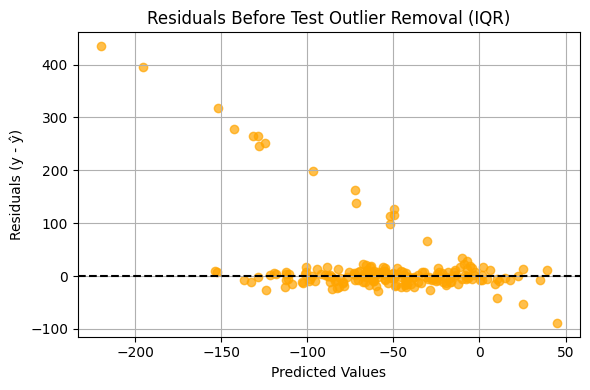

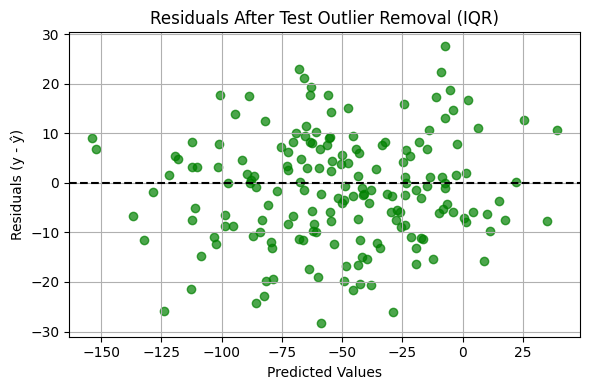

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_test, residuals, color='orange', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals Before Test Outlier Removal (IQR)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y - ŷ)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Residuals After Test Outlier Removal (Scatter Plot)
residuals_after = y_test_clean - y_pred_final

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_final, residuals_after, color='green', alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals After Test Outlier Removal (IQR)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y - ŷ)")
plt.grid(True)
plt.tight_layout()
plt.show()